# **Milestone 5:**

Final analysis:

*   distribution of the three categories
*   bigrams of the corpus
*   lists of key phrases



### **Setting up the environment**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Installing requirements

In [2]:
%%capture
!pip install --upgrade transformers  # make sure compatible with tokenizers
!wget https://raw.githubusercontent.com/crow-intelligence/growth-hacking-sentiment/master/requirements.txt
!pip install -r requirements.txt
!pip install nltk==3.4

Installing apex

In [4]:
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Overwriting setup.sh


Writing setup.sh

In [5]:
%%capture
!sh setup.sh

###**Importing the required modules**

In [7]:
# importing relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import altair as alt

import nltk
from nltk import bigrams
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from simpletransformers.classification import ClassificationModel

from keyness import log_likelihood

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Making predictions with the saved model on the big corpus textfile**

Loading in the big corpus reviews

In [66]:
# importing and reading txt from drive
with open("/content/drive/MyDrive/Sentiment Analysis for Marketing/data/reviews_without_ratings2.txt", "r") as f:
    reviews = f.read().split("\n")

print(len(reviews))

100000


Loading the model

In [67]:
# loading the previously saved model from drive
model2 = ClassificationModel(
    model_type="distilbert",
    model_name= "/content/drive/MyDrive/Sentiment Analysis for Marketing/outputs_2/best_model",
    use_cuda=True,
    num_labels=3,
    args={
        "output_dir": "/content/drive/MyDrive/Sentiment Analysis for Marketing/outputs_2/best_model",
        "reprocess_input_data": True,
        "sliding_window": True,
        "max_seq_length": 512,
    },
)

Making predictions

In [68]:
# predicting results for all reviews
preds = model2.predict(reviews)

predicted_class, predicted_probas = preds[0], preds[1]

  0%|          | 0/100000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (717 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/5666 [00:00<?, ?it/s]

In [69]:
# saving the results to pickle
import pickle
with open("/content/drive/MyDrive/Sentiment Analysis for Marketing/predicted_class.pkl", "wb") as outfile:
  pickle.dump(predicted_class, outfile)

with open("/content/drive/MyDrive/Sentiment Analysis for Marketing/predicted_probs.pkl", "wb") as outfile:
  pickle.dump(predicted_probas, outfile)

### **Analyzing the predictions**

In [70]:
# loading the results from drive
predicted_class = pickle.load(open("/content/drive/MyDrive/Sentiment Analysis for Marketing/predicted_class.pkl", "rb"))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


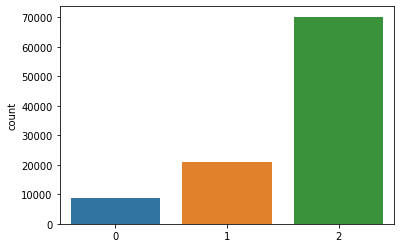

In [71]:
# plotting the class distribution
# 0 = negative; 1 = neutral; 2 = positive
sns.countplot(predicted_class)

In [72]:
# preprocessing and tokenizing the reviews
stopword_list = set(stopwords.words())

def tokenize_review(review):
  '''
  input: 
    review: a sentence of the reviews
  output:
    tokens: the cleaned and tokenized sentence
  '''
  tokens = []
  for s in sent_tokenize(review):
    for w in word_tokenize(s):
      if w.lower() not in stopword_list and w.isalpha():
        tokens.append(w.lower())
  return tokens

In [73]:
# running the tokenizing function
reviews = [tokenize_review(r) for r in reviews]

In [74]:
# printing some preprocessed tokens
print(reviews[:20])

[['pros', 'luring', 'graphics', 'graphic', 'artist', 'mean', 'since', 'mysims', 'racing', 'excitebots', 'overly', 'popular', 'game', 'huge', 'disappointment', 'boring', 'zones', 'speed', 'extremely', 'lame', 'simulation', 'music', 'sound', 'effect', 'controls', 'means', 'listen', 'primitive', 'noises', 'included', 'music', 'reason', 'nascar', 'kart', 'racing', 'thrown', 'garbage', 'house', 'far', 'found', 'additional', 'mysims', 'racing', 'game'], ['make', 'simple', 'noone', 'wastes', 'time', 'like', 'player', 'games', 'internet', 'friends', 'game', 'great', 'colorful', 'smooth', 'graphics', 'great', 'characters', 'well', 'written', 'plot', 'like', 'everyone', 'else', 'world', 'internet', 'waiting', 'play', 'campaign', 'online', 'friends', 'split', 'screen', 'campaign', 'buddy', 'little', 'brother', 'youve', 'duped', 'cause', 'online', 'splitscreen', 'campaign', 'mode', 'makes', 'worste', 'laziest', 'move', 'ever', 'even', 'deceiving', 'cause', 'box', 'says', 'players', 'online', 'that

In [75]:
# generating bigrams since bare words as keywords do not tell much without context
# using the bigram function of the NLTK package
bigrams = [[b[0] + "_" + b[1] for b in list(nltk.bigrams(b))] for b in reviews]

# splitting bigrams into classes
neg_reviews = [bigrams[i] for i in range(len(reviews)) if predicted_class[i] == 0]
neutral_reviews = [bigrams[i] for i in range(len(reviews)) if predicted_class[i] == 1]
pos_reviews = [bigrams[i] for i in range(len(reviews)) if predicted_class[i] == 2]

In [76]:
print(neg_reviews[:10])

[['pros_luring', 'luring_graphics', 'graphics_graphic', 'graphic_artist', 'artist_mean', 'mean_since', 'since_mysims', 'mysims_racing', 'racing_excitebots', 'excitebots_overly', 'overly_popular', 'popular_game', 'game_huge', 'huge_disappointment', 'disappointment_boring', 'boring_zones', 'zones_speed', 'speed_extremely', 'extremely_lame', 'lame_simulation', 'simulation_music', 'music_sound', 'sound_effect', 'effect_controls', 'controls_means', 'means_listen', 'listen_primitive', 'primitive_noises', 'noises_included', 'included_music', 'music_reason', 'reason_nascar', 'nascar_kart', 'kart_racing', 'racing_thrown', 'thrown_garbage', 'garbage_house', 'house_far', 'far_found', 'found_additional', 'additional_mysims', 'mysims_racing', 'racing_game'], ['make_simple', 'simple_noone', 'noone_wastes', 'wastes_time', 'time_like', 'like_player', 'player_games', 'games_internet', 'internet_friends', 'friends_game', 'game_great', 'great_colorful', 'colorful_smooth', 'smooth_graphics', 'graphics_gre

In [77]:
# the log_likelihood() function compares the frequencies of tokens or ngrams in a corpus and reference corpus, rank ordering the output by the log likelihood values of the corpus
# it returns a rank ordered list with the following data in each item: - the item - its log likelihood value - its frequency in the corpus - its frequency in the reference corpus
positive_keys = log_likelihood(bigrams, pos_reviews)[:150]
neutral_keys = log_likelihood(bigrams, neutral_reviews)[:150]
negative_keys = log_likelihood(bigrams, neg_reviews)[:150]

In [94]:
# creating a corresponding dataframe for the positive keys
positive_df = pd.DataFrame({"bigrams": [k[0] for k in positive_keys],
                     "log_likelihood": [k[1] for k in positive_keys],
                     "corpus_freq": [k[2] for k in positive_keys],
                     "reference_freq": [k[3] for k in positive_keys]})
print(positive_df[:30])

               bigrams  log_likelihood  corpus_freq  reference_freq
0           great_game         751.070         5891            4715
1            love_game         381.155         2455            2062
2          works_great         342.545         1744            1559
3     highly_recommend         246.975         1735            1426
4           game_great         210.647         2476            1814
5        great_product         185.683          785             740
6         awesome_game         163.205          942             814
7           best_games         154.765         1006             843
8            best_game         151.871         1184             949
9             fun_game         139.827         3283            2129
10         great_price         123.573          644             572
11         waste_money         111.314          491              71
12  highly_recommended         110.169          621             540
13   excellent_product         109.682          

In [100]:
# plotting keyness against frequency
alt.Chart(positive_df).mark_point().encode(
    x='log_likelihood:Q',
    y='reference_freq:Q',
    color='reference_freq:Q',
    tooltip=["bigrams:N", "reference_freq:Q"],
).interactive()

alt.Chart(...)

In [96]:
# creating a corresponding dataframe for the neutral keys
neutral_df = pd.DataFrame({"bigrams": [k[0] for k in neutral_keys],
                     "log_likelihood": [k[1] for k in neutral_keys],
                     "corpus_freq": [k[2] for k in neutral_keys],
                     "reference_freq": [k[3] for k in neutral_keys]})
print(neutral_df[:10])

             bigrams  log_likelihood  corpus_freq  reference_freq
0         great_game        1000.079         5891            1049
1        works_great         663.100         1744             136
2          love_game         601.695         2455             329
3      great_product         417.786          785              28
4   highly_recommend         334.775         1735             283
5      fast_shipping         263.892          347               0
6  excellent_product         256.256          401               6
7       awesome_game         253.919          942             115
8         loves_game         230.713          374               7
9         game_great         229.343         2476             599


In [95]:
# creating a corresponding dataframe for the negative keys
negative_df = pd.DataFrame({"bigrams": [k[0] for k in negative_keys],
                     "log_likelihood": [k[1] for k in negative_keys],
                     "corpus_freq": [k[2] for k in negative_keys],
                     "reference_freq": [k[3] for k in negative_keys]})
print(negative_df[:30])

             bigrams  log_likelihood  corpus_freq  reference_freq
0        waste_money         657.154          491             307
1         great_game         280.249         5891             127
2    stopped_working         262.083          194             122
3         worst_game         219.430          166             103
4         waste_time         207.810          411             148
5         save_money         192.842          340             130
6   customer_service         185.538          184              97
7           buy_game         157.950         1671             294
8         would_work         146.038          255              98
9          never_buy         142.595          121              70
10       worst_games         129.999           82              57
11        game_sucks         127.945          161              74
12      tech_support         124.639           80              55
13           lot_fun         122.898         1767              24
14     gam

In [104]:
# plotting keyness against frequency
alt.Chart(negative_df).mark_point().encode(
    x='log_likelihood:Q',
    y='reference_freq:Q',
    color='reference_freq:Q',
    tooltip=["bigrams:N", "reference_freq:Q"],
).interactive()

alt.Chart(...)

Summary: 

*While inspecting the positive and negative keywords, the results indicate:*
*   *the average user seems to like the game, since commendatory keywords outweigh the negative ones in terms of frequency*
*   *potential for improvement might exist with respect to the customer support ("tech support", "customer service")*

